In [37]:
pip install category-encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Problem statement

**Context : **

Hotel di Negara Portugal ingin mendapatkan customer yang tidak akan membatalkan booking hotel. Maka dari itu pihak hotel ingin mengetahui customer yang seperti apa yang tidak membatalkan pemesanan.
Target :

0 : Tidak membatalkan booking

1 : Membatalkan booking

**Problem Statement :**

Pihak hotel kesulitan menilai customer dengan karakteristik seperti apa yang tidak akan melakukan pembatalan booking. 

**Goals :**

Pihak hotel mendapatkan karakteristik customer yang berpotensi tinggi tidak membatalkan booking, sehingga jika kedepannya ada karakteristik customer yang sesuai dengan prediksi dapat di layani dengan baik, agar customer ini tidak akan membatalkan proses booking. 


**Analytic Approach :**

Yang dilakukan adalah melihat karakteristik customer yang berpotensi tidak membatalkan pemesanan hotel.

Kemudian kita akan membangun model klasifikasi yang akan membantu perusahaan untuk dapat memprediksi customer yang tidak akan membatalkan pemesanan hotel.

**Metrics Evaluation**

Type I (False Positive): Diprediksi membatalkan  pemesanan padahal sebenarnya tidak membatalkan pemesanan

Type II (False Negative): Diprediksi tidak membatalkan pemesanan padahal sebenarnya membatalkan pemesanan

**Constraint**

Model tersebut diharapkan dapat memprediksi sebanyak mungkin customer yang tidak membatalkan pemesanan hotel


Metrik evaluasi apa yang cocok untuk digunakan pada kasus ini? (recall) karena kita hanya ingin mencari customer yang benar-benar2 tidak akan membatalkan pesanan hotel.


In [265]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from category_encoders import BinaryEncoder 
from sklearn.compose import ColumnTransformer

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score,RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)


##Exploration & Analysis

In [41]:
df=pd.read_csv(r"data_hotel_booking_demand.csv")

In [42]:
df

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...
83568,PRT,Online TA,0,0,No Deposit,0,Contract,A,0,3,1
83569,FRA,Online TA,0,0,No Deposit,0,Transient,D,0,2,0
83570,PRT,Online TA,0,1,No Deposit,0,Transient,D,0,3,0
83571,CN,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0


In [43]:
df.describe()

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_canceled
count,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000
mean,0.086798,0.220897,2.330561,0.062999,0.573211,0.368277
std,0.841011,0.648635,17.673051,0.246919,0.795163,0.482340
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,26.000000,21.000000,391.000000,8.000000,5.000000,1.000000


In [44]:
df.describe(include='object')

,country,market_segment,deposit_type,customer_type,reserved_room_type
count,83222,83573,83573,83573,83573
unique,162,8,3,4,10
top,PRT,Online TA,No Deposit,Transient,A
freq,34097,39460,73352,62732,60041


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      83222 non-null  object
 1   market_segment               83573 non-null  object
 2   previous_cancellations       83573 non-null  int64 
 3   booking_changes              83573 non-null  int64 
 4   deposit_type                 83573 non-null  object
 5   days_in_waiting_list         83573 non-null  int64 
 6   customer_type                83573 non-null  object
 7   reserved_room_type           83573 non-null  object
 8   required_car_parking_spaces  83573 non-null  int64 
 9   total_of_special_requests    83573 non-null  int64 
 10  is_canceled                  83573 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 7.0+ MB


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


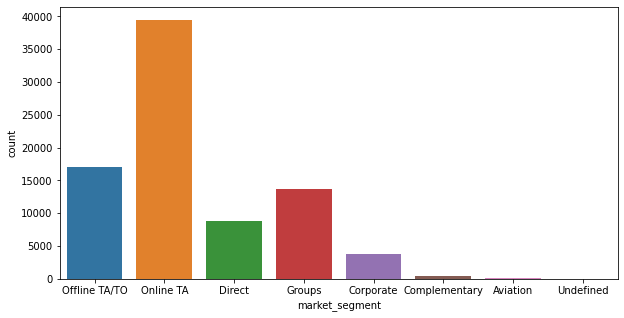

In [46]:
plt.figure(figsize = (10,5))
sns.countplot(df['market_segment'])
plt.show()

Pada **market_segment** yang memiliki angka. terbesar adalag Online TA

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


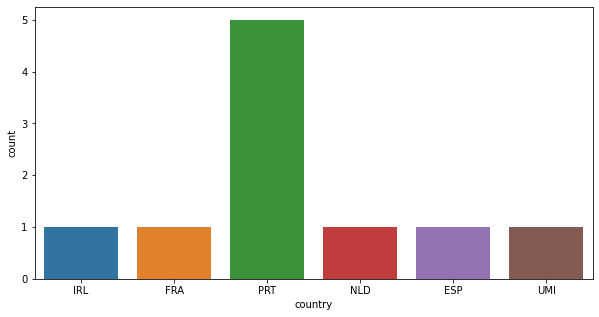

In [47]:
plt.figure(figsize = (10,5))
sns.countplot(df['country'].head(10))
plt.show()

Sedangkan pada **country** atau negara terbesar yang melakukan booking adalah PRT atau Portugal.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


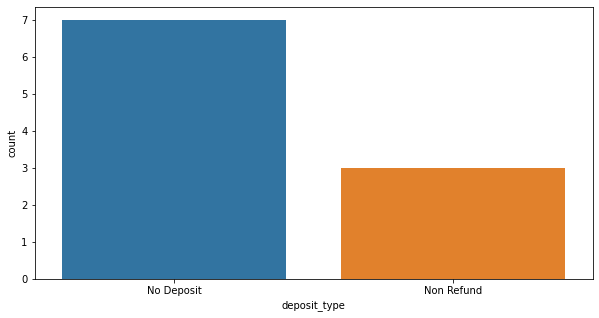

In [48]:
plt.figure(figsize = (10,5))
sns.countplot(df['deposit_type'].head(10))
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


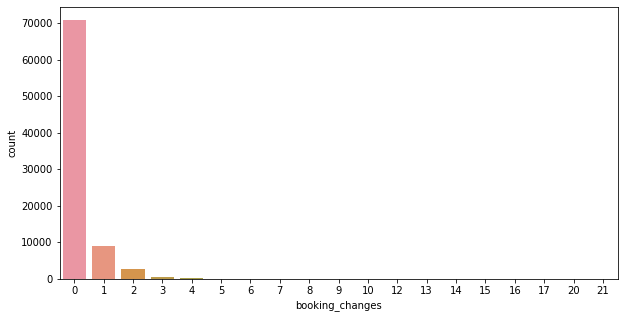

In [49]:
plt.figure(figsize = (10,5))
sns.countplot(df['booking_changes'])
plt.show()

In [50]:
df['days_in_waiting_list'].unique()

array([  0,   3,  39,  87,  77, 215,  97, 162,  46,  79,   4,  31, 122,
        34,  57, 259,  50,  17,  32,  43,  75,  69,  44,  22, 113,  58,
        38,  65,  48, 236, 176,  25, 108,  91,  19, 160,  68,  28,  63,
        35,  42,  59,  24,   8, 183, 187,  21, 111,  56,  98, 101,  15,
        16,  47,  93,  45,  14,  70,  10,  49, 178,  99,  60,  40,  85,
       223,   6,  33, 391,  20,   1,  41, 147,  55,  80, 379, 150,  61,
       330, 174, 107,  96,  18,  62,  13,  30, 120,  27, 207,  71,   2,
        76, 125,   5,   9, 224,  53,  83,  84,  12,  73, 100,  92,  23,
        11, 105,  26, 193,   7, 165,  74, 121,  36,  64, 185])

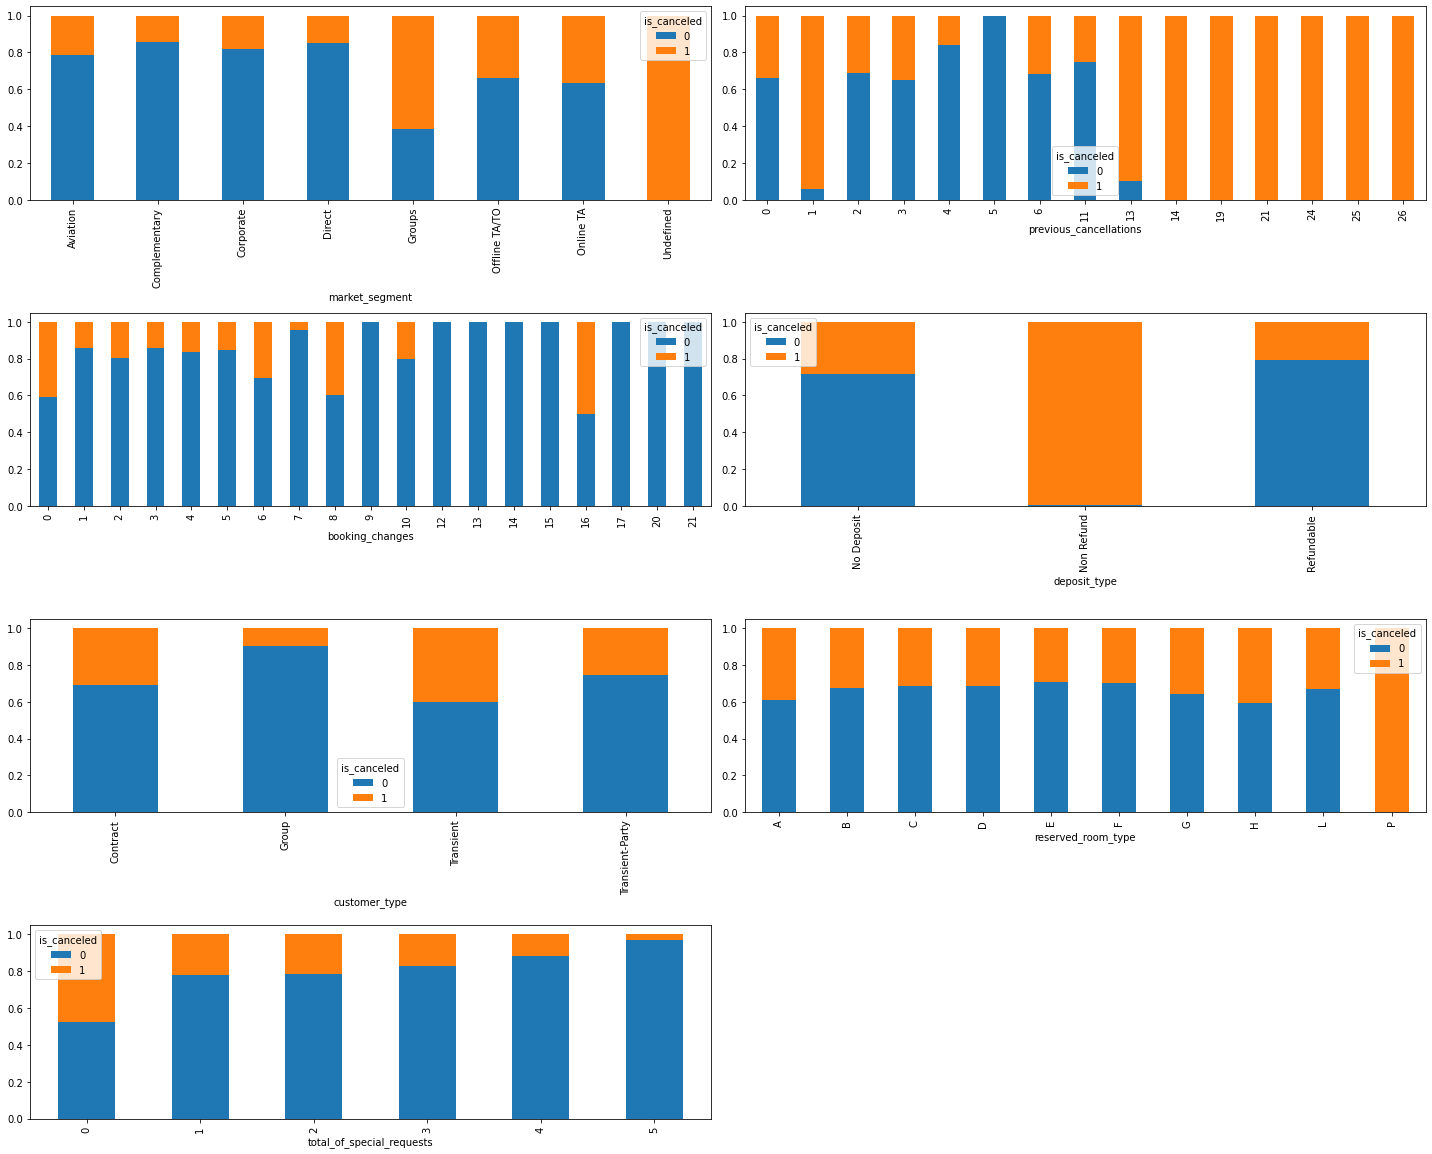

In [51]:
count = 0
fig = plt.figure(figsize=(20,20))

for i in df.drop(columns=['is_canceled','days_in_waiting_list','country','required_car_parking_spaces']).columns:
    count +=1
    ax= plt.subplot(5,2,count)
    pd.crosstab(df[i],df['is_canceled'],normalize=0).plot(kind='bar',stacked=True,ax=ax)
    fig.tight_layout()

plt.show()

In [52]:
df.columns

Index(['country', 'market_segment', 'previous_cancellations',
       'booking_changes', 'deposit_type', 'days_in_waiting_list',
       'customer_type', 'reserved_room_type', 'required_car_parking_spaces',
       'total_of_special_requests', 'is_canceled'],
      dtype='object')

1.Pada perbandigan **is_canceled** dengan **market_segment** bahwa yang paling banyak melakukan cancel booking adalah Groups
1. Pada perbandigan **is_canceled** dengan **previous_cancellations** bahwa yang paling banyak tidak melakukan cancel booking adalah customer yang telah melakukan pembatalan 5x kali booking sebelumnya
1. Pada perbandigan **is_canceled** dengan **deposit_type** bahwa yang paling banyak melakukan cancel booking adalah yang tipe depositnya Non-Refund
1. Pada perbandigan **is_canceled** dengan **customer_type** bahwa yang paling banyak melakukan cancel booking adalah yang tipe customer transcient
1. Pada perbandigan **is_canceled** dengan **reserved_room_type** bahwa yang paling banyak melakukan cancel booking adalah yang tipe kamarnya type E
1. Pada perbandigan **is_canceled** dengan **total_of_special_requests** bahwa yang paling banyak melakukan cancel booking adalah yang tidak memiliki special request

In [53]:
df['is_canceled'].value_counts()/df.shape[0]*100

0    63.172316
1    36.827684
Name: is_canceled, dtype: float64

Dapat dilihat dari hasil diatas terdapat imbalance dataset

In [54]:
correlation = df.corr()['is_canceled'].abs().sort_values(ascending = False)
correlation

is_canceled                    1.000000
total_of_special_requests      0.235993
required_car_parking_spaces    0.194807
booking_changes                0.145746
previous_cancellations         0.109598
days_in_waiting_list           0.056203
Name: is_canceled, dtype: float64

##Data Preparation

In [55]:
df.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


In [56]:
df.describe(include='object')

,country,market_segment,deposit_type,customer_type,reserved_room_type
count,83222,83573,83573,83573,83573
unique,162,8,3,4,10
top,PRT,Online TA,No Deposit,Transient,A
freq,34097,39460,73352,62732,60041


In [57]:
df.columns

Index(['country', 'market_segment', 'previous_cancellations',
       'booking_changes', 'deposit_type', 'days_in_waiting_list',
       'customer_type', 'reserved_room_type', 'required_car_parking_spaces',
       'total_of_special_requests', 'is_canceled'],
      dtype='object')

1. Mengencoding `country` menggunakan Binary Encoding, karena fitur ini memiliki unique data yang banyak (162 data unik) dan tidak memiliki urutan/tidak ordinal. 
1. Mengencoding `market_segment` menggunakan Binary Enconding, karena fitur ini memiliki unique data yang banyak (8 data unik) dan tidak memiliki urutan/tidak ordinal
1. Mengencoding `deposit_type` menggunakan One Hot Encoding, karena fitur ini memiliki unique data yang sedikit (3 data unik).
1. Mengencoding `customer_type` menggunakan One Hot Encoding, karena fitur ini memiliki unique data yang sedikit(4 data unik).
1. Mengencoding `reserved_room_type` menggunakan Binary Encoding, karena fitur ini memiliki unique data yang banyak (10 data unik )dan tidak memilik urutan/tidak ordinal.


In [58]:
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), ['deposit_type','customer_type']),
    ('binary', BinaryEncoder(), ['country','market_segment','reserved_room_type'])
], remainder='passthrough')

In [59]:
x = df.drop(columns=['is_canceled'])
y = df['is_canceled']

In [60]:
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y,test_size=0.2,random_state=2021)

In [61]:
testing = pd.DataFrame(transformer.fit_transform(x_train),columns=transformer.get_feature_names())
testing.head()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/category_encoders/utils.py:360: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


,onehot__x0_Non Refund,onehot__x0_Refundable,onehot__x1_Group,onehot__x1_Transient,onehot__x1_Transient-Party,binary__country_0,binary__country_1,binary__country_2,binary__country_3,binary__country_4,binary__country_5,binary__country_6,binary__country_7,binary__market_segment_0,binary__market_segment_1,binary__market_segment_2,binary__market_segment_3,binary__reserved_room_type_0,binary__reserved_room_type_1,binary__reserved_room_type_2,binary__reserved_room_type_3,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model Evaluation

In [135]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()
lgbm = lgb.LGBMClassifier()

**`Model benchmark : K-Fold`**

In [238]:
models = [logreg,knn,dt,rf,xgb,lgbm]
score=[]
rata=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=5) 
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)]) 
    model_cv=cross_val_score(estimator,x_train,y_train,cv=skfold,scoring='recall')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],'mean':rata,'sdev':std}).set_index('model').sort_values(by='mean',ascending=False)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

,mean,sdev
model,,
Random Forest,0.695679,0.006941
Decision Tree,0.690155,0.005555
LightGBM,0.690115,0.006174
KNN,0.663918,0.016753
XGBoost,0.610713,0.016189
Logistic Regression,0.563764,0.011262


1. Membuat sebuah objek StratifiedKFold yang digunakan untuk melakukan cross-validation dengan skema k-fold. Dalam contoh ini, digunakan n_splits=5 untuk membagi data menjadi 5 subset.
1. Membuat pipeline yang terdiri dari 2 tahap yang pertama (preprocess) yang kedua (model)
1. Melakukan cross-validation dengan memanggil fungsi cross_val_score(). Fungsi ini akan mengembalikan skor evaluasi untuk setiap subset pada data yang telah dibagi menggunakan StratifiedKFold. Skor yang digunakan untuk evaluasi adalah 'recall'. Hasil evaluasi disimpan dalam variabel model_cv.
1. Membuat sebuah data frame pandas yang berisi tiga kolom: model, mean, dan sdev. Kolom model berisi nama model machine learning yang telah dievaluasi. Kolom mean berisi nilai rata-rata dari skor evaluasi. Kolom sdev berisi nilai standar deviasi dari skor evaluasi. Kemudian data frame diurutkan berdasarkan nilai rata-rata skor evaluasi secara menurun.



**Model Benchmark : Train and tes**

In [240]:
import numpy as np

def train(model, x_train, y_train):
    estimator = Pipeline([
        ("Preprocessing", transformer),
        ("Model", model)
    ])
    score = cross_val_score(estimator, x_train, y_train, scoring='recall')
    
    return score, np.mean(score), np.std(score), estimator

1. Membuat sebuah fungsi bernama train dengan tiga parameter input, yaitu objek model machine learning (model), variabel x_train (x_train), dan variabel y_train (y_train).
1. Membuat sebuah pipeline yang terdiri dari dua tahap: tahap pertama Preprocessing dan tahap kedua Model.

1. Melakukan cross-validation dengan memanggil fungsi cross_val_score(). Fungsi ini akan mengembalikan skor evaluasi untuk setiap subset pada data yang telah dibagi menggunakan skema k-fold. Skor yang digunakan untuk evaluasi adalah 'precision' (presisi). Hasil evaluasi disimpan dalam variabel score.





In [241]:
models = [logreg, dt, knn,rf,xgb,lgbm]
result_evaluation = {"model":[], 
                     "mean_score":[],
                     "score_val":[],
                     "std_score":[]}

for model in models:
    scores = train(model, x_train, y_train) # Bentuknya list [score, score.mean()]
    result_evaluation['model'].append(model)
    result_evaluation['mean_score'].append(scores[1])
    result_evaluation['score_val'].append(scores[0])
    result_evaluation['std_score'].append(scores[2])

pd.DataFrame(result_evaluation)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

,model,mean_score,score_val,std_score
0,LogisticRegression(),0.563764,"[0.5499593826157595, 0.5583756345177665, 0.560...",0.011262
1,DecisionTreeClassifier(),0.689912,"[0.6846060113728676, 0.692994923857868, 0.6840...",0.005513
2,KNeighborsClassifier(),0.663918,"[0.6917140536149472, 0.6663959390862945, 0.668...",0.016753
3,RandomForestClassifier(),0.695192,"[0.6955727051177905, 0.6962436548223351, 0.684...",0.007129
4,XGBClassifier(),0.610713,"[0.6074329813160032, 0.6109644670050761, 0.640...",0.016189
5,LGBMClassifier(),0.690115,"[0.6988220958570268, 0.6911675126903554, 0.684...",0.006174


In [242]:
def calc_train_error(X_train, y_train, model):
#     '''returns in-sample error for already fit model.'''
       
    # Predict on the test set using the trained model
    predictions = model.predict(X_train)
    predictProba = model.predict_proba(X_train)
    
    # Calculate the evaluation metrics
    accuracy = accuracy_score(y_train, predictions)
    f1 = f1_score(y_train, predictions, average='macro')
    roc_auc = roc_auc_score(y_train, predictProba[:,1])
    recall = recall_score(y_train, predictions)
    precision = precision_score(y_train, predictions)
    report = classification_report(y_train, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    

def calc_validation_error(X_test, y_test, model):
#     '''returns out-of-sample error for already fit model.'''

     # Predict on the test set using the trained model
    predictions = model.predict(X_test)
    predictProba = model.predict_proba(X_test)

     # Calculate the evaluation metrics
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='macro')
    roc_auc = roc_auc_score(y_test, predictProba[:,1])
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Calculate the in-sample error and out-of-sample error
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)

    # Return the in-sample error and out-of-sample error

    return train_error, validation_error

In [243]:
from sklearn.model_selection import StratifiedKFold

K = 10
kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

Membuat object k-fold cross validation dengan n_splits=K, yaitu jumlah fold yang akan digunakan, shuffle=True yang berarti data akan diacak sebelum di-split menjadi K-fold 

In [244]:
data = x_train
target = y_train

In [246]:
train_errors_without_oversampling = []
validation_errors_without_oversampling = []

train_errors_with_oversampling = []
validation_errors_with_oversampling = []

for train_index, val_index in kf.split(data, target):
    
    X_train, X_val = data.iloc[train_index], data.iloc[val_index]
    Y_train, Y_val = target.iloc[train_index], target.iloc[val_index]
    
    ros = RandomOverSampler()

    X_ros, Y_ros = ros.fit_resample(X_train, Y_train)

    rf = RandomForestClassifier()
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',rf)
    ])

    train_error_without_oversampling, val_error_without_oversampling = calc_metrics(X_train, Y_train, X_val, Y_val, estimator)
    train_error_with_oversampling, val_error_with_oversampling = calc_metrics(X_ros, Y_ros, X_val, Y_val, estimator)
    
    train_errors_without_oversampling.append(train_error_without_oversampling)
    validation_errors_without_oversampling.append(val_error_without_oversampling)
    
    train_errors_with_oversampling.append(train_error_with_oversampling)
    validation_errors_with_oversampling.append(val_error_with_oversampling)

Kode tersebut melakukan iterasi sebanyak K kali, di mana K merupakan jumlah fold pada Stratified K-Fold Cross Validation. Pada setiap iterasi, data dibagi menjadi data latih (X_train, Y_train) dan data validasi (X_val, Y_val) menggunakan kf.split(). Selanjutnya, dilakukan oversampling pada data latih dengan menggunakan RandomOverSampler dari library imblearn.

Setelah itu, model RandomForestClassifier di-instantiate dalam pipeline. Preprocessing dilakukan menggunakan transformer (di mana transformer adalah instance dari Transformer yang telah di-instantiate sebelumnya) dan model yang dijadikan estimasi adalah rf (yaitu model RandomForestClassifier yang sudah di-instantiate sebelumnya).

Setelah model di-instantiate, dilakukan perhitungan train_error dan validation_error dengan memanggil fungsi calc_metrics, di mana sebagai parameter diberikan data latih dan data validasi (baik yang telah di-oversampling maupun tidak) serta model yang sudah di-instantiate. Kemudian, error tersebut di-append ke dalam masing-masing list, yaitu train_errors_without_oversampling, validation_errors_without_oversampling, train_errors_with_oversampling, dan validation_errors_with_oversampling.

**Tanpa Oversampling**

In [247]:
listItem = []

for tr,val in zip(train_errors_without_oversampling,validation_errors_without_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.828309,0.808555,0.916715,0.890530,0.812789,0.791231,0.733664,0.706742,0.785904,0.757180
1,0.827844,0.812743,0.916473,0.891569,0.811751,0.794381,0.726986,0.697807,0.788971,0.771788
2,0.827578,0.812145,0.916251,0.892256,0.810770,0.794680,0.718953,0.706742,0.793466,0.765172
3,0.829023,0.801825,0.917228,0.883109,0.812988,0.782499,0.727978,0.683997,0.791095,0.754818
4,0.828940,0.804218,0.916876,0.888377,0.812891,0.785460,0.727798,0.690496,0.791015,0.756564
5,0.827910,0.811995,0.916575,0.891402,0.811623,0.792085,0.724819,0.682372,0.790492,0.779582
6,0.828409,0.807060,0.916655,0.890162,0.812488,0.790071,0.729139,0.709298,0.788916,0.752693
7,0.828575,0.807060,0.916691,0.887497,0.812602,0.789442,0.728598,0.702801,0.789641,0.756225
8,0.827896,0.810920,0.916367,0.892758,0.812044,0.793590,0.729738,0.707555,0.787370,0.762030
9,0.827331,0.815707,0.916049,0.893918,0.811483,0.797768,0.729603,0.703087,0.786152,0.775538


**Dengan Oversampling**

In [248]:
listItem = []

for tr,val in zip(train_errors_with_oversampling,validation_errors_with_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.820373,0.792103,0.917516,0.889704,0.820259,0.784142,0.845496,0.814785,0.805045,0.682313
1,0.820820,0.788214,0.917655,0.891057,0.820591,0.780467,0.856545,0.815191,0.799425,0.676213
2,0.820662,0.793449,0.918087,0.891347,0.820577,0.785424,0.842471,0.814785,0.807260,0.684408
3,0.821320,0.785971,0.918330,0.882419,0.821222,0.777413,0.844733,0.800975,0.806946,0.676965
4,0.821070,0.790308,0.918263,0.886967,0.820962,0.781750,0.845549,0.804224,0.806084,0.682759
5,0.821570,0.788065,0.918421,0.890479,0.821328,0.779346,0.858308,0.800162,0.799559,0.680484
6,0.820943,0.791654,0.918542,0.889769,0.820776,0.784515,0.851446,0.827446,0.802489,0.677977
7,0.821127,0.786569,0.918168,0.886101,0.821048,0.778116,0.842186,0.802680,0.808149,0.677519
8,0.821311,0.790726,0.917972,0.891585,0.821193,0.782864,0.847000,0.815191,0.805610,0.680108
9,0.819404,0.794016,0.916831,0.893495,0.819242,0.785554,0.849341,0.808286,0.801360,0.687392


In [249]:
for rep in validation_errors_without_oversampling :
    print(rep['report'])

              precision    recall  f1-score   support

           0       0.84      0.87      0.85      4224
           1       0.76      0.71      0.73      2462

    accuracy                           0.81      6686
   macro avg       0.80      0.79      0.79      6686
weighted avg       0.81      0.81      0.81      6686

              precision    recall  f1-score   support

           0       0.83      0.88      0.86      4224
           1       0.77      0.70      0.73      2462

    accuracy                           0.81      6686
   macro avg       0.80      0.79      0.79      6686
weighted avg       0.81      0.81      0.81      6686

              precision    recall  f1-score   support

           0       0.84      0.87      0.85      4224
           1       0.77      0.71      0.73      2462

    accuracy                           0.81      6686
   macro avg       0.80      0.79      0.79      6686
weighted avg       0.81      0.81      0.81      6686

              preci

In [250]:
for rep in validation_errors_with_oversampling :
    print(rep['report'])

              precision    recall  f1-score   support

           0       0.88      0.78      0.83      4224
           1       0.68      0.81      0.74      2462

    accuracy                           0.79      6686
   macro avg       0.78      0.80      0.78      6686
weighted avg       0.81      0.79      0.80      6686

              precision    recall  f1-score   support

           0       0.88      0.77      0.82      4224
           1       0.68      0.82      0.74      2462

    accuracy                           0.79      6686
   macro avg       0.78      0.79      0.78      6686
weighted avg       0.80      0.79      0.79      6686

              precision    recall  f1-score   support

           0       0.88      0.78      0.83      4224
           1       0.68      0.81      0.74      2462

    accuracy                           0.79      6686
   macro avg       0.78      0.80      0.79      6686
weighted avg       0.81      0.79      0.80      6686

              preci

Disini memang terlihat bahwa data yang tidak di oversampling pada nilai positif nya lebih bagus, tapi tetap saya gunakan yang oversampling supaya hasil yang dihasilkan mempunyai akurat yang baik. 

##Hyperparameter Tuning

In [293]:
rf =RandomForestClassifier()
ros = RandomOverSampler(random_state=42)

estimator=Pipeline([
    ('oversampling',ros),
    ('preprocess',transformer),
    ('model',rf)
])

In [294]:
param_grid = [{
    'model__n_estimators': [50,75,100],
    'model__criterion': ['gini', 'entropy', 'log_loss'],
    'model__max_depth': [50,75,100],
}]


In [295]:
grid = RandomizedSearchCV(estimator,
                        param_grid,
                        n_iter=10,
                        scoring='recall',
                        random_state=42,
                        verbose=1,
                        cv=kf)

In [296]:
grid.fit(x_train, y_train)
print(grid.best_score_)
print(grid.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/usr/local/lib/python3.8/dist-packages/jobli

0.8107377983761621
{'model__n_estimators': 75, 'model__max_depth': 75, 'model__criterion': 'entropy'}


In [297]:
best_model = grid.best_estimator_
best_model.fit(x_train, y_train)

Pipeline(steps=[('oversampling', RandomOverSampler(random_state=42)),
                ('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['deposit_type',
                                                   'customer_type']),
                                                 ('binary', BinaryEncoder(),
                                                  ['country', 'market_segment',
                                                   'reserved_room_type'])])),
                ('model',
                 RandomForestClassifier(criterion='entropy', max_depth=75,
                                        n_estimators=75))])

In [298]:
estimator=Pipeline([
    ('oversampling',ros),
    ('preprocess',transformer),
    ('model',rf)
])
estimator.fit(x_train, y_train)

Pipeline(steps=[('oversampling', RandomOverSampler(random_state=42)),
                ('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['deposit_type',
                                                   'customer_type']),
                                                 ('binary', BinaryEncoder(),
                                                  ['country', 'market_segment',
                                                   'reserved_room_type'])])),
                ('model', RandomForestClassifier())])

In [300]:
Recall_before_tuning = recall_score(y_test, estimator.fit(x_train, y_train).predict(x_test))
Recall_after_tuning = recall_score(y_test, grid.best_estimator_.predict(x_test))
print("Recall Score Before Tuning:", Recall_before_tuning)
print("Recall Score After Tuning:", Recall_after_tuning)

Recall Score Before Tuning: 0.807504873294347
Recall Score After Tuning: 0.8092917478882391


In [301]:
y_pred_before_tuning = estimator.fit(x_train, y_train).predict(x_test)
y_pred_after_tuning = grid.best_estimator_.predict(x_test)

In [302]:
report_default = classification_report(y_test, y_pred_before_tuning)
report_tuned = classification_report(y_test, y_pred_after_tuning)

print('Classification Report before RF : \n', report_default)
print('Classification Report after RF : \n', report_tuned)

Classification Report before RF : 
               precision    recall  f1-score   support

           0       0.88      0.78      0.82     10559
           1       0.68      0.81      0.74      6156

    accuracy                           0.79     16715
   macro avg       0.78      0.79      0.78     16715
weighted avg       0.80      0.79      0.79     16715

Classification Report after RF : 
               precision    recall  f1-score   support

           0       0.88      0.78      0.83     10559
           1       0.68      0.81      0.74      6156

    accuracy                           0.79     16715
   macro avg       0.78      0.80      0.78     16715
weighted avg       0.80      0.79      0.79     16715



##Feature Importance

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/category_encoders/utils.py:360: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


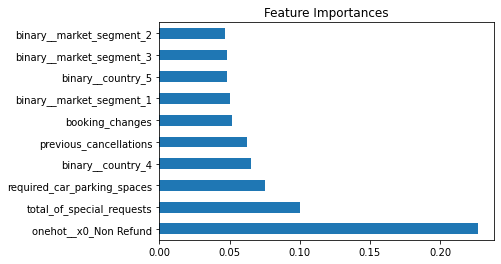

In [305]:
feat = pd.Series(best_model['model'].feature_importances_, transformer.get_feature_names()).sort_values(ascending = False).head(10)
feat.plot(kind='barh', title='Feature Importances')
plt.show()

Dari hasil feature importace di atas dapat dilihat fitur 'Non Refund','Total_of_special_request','dan 'required_car_parking_spaces' menempati urutan 3 teratas yang sangat berpengaruh terhadap customer melakukan pembatalan atau tidak. 


## Conclusion & Recommendation




In [304]:
print('Classification Report Tuned Random Forest : \n', report_tuned)

Classification Report Tuned Random Forest : 
               precision    recall  f1-score   support

           0       0.88      0.78      0.83     10559
           1       0.68      0.81      0.74      6156

    accuracy                           0.79     16715
   macro avg       0.78      0.80      0.78     16715
weighted avg       0.80      0.79      0.79     16715



Dari hasil classification report di atas dapat disimpulkan bahwa jika kedepan model yang dibuat ini digunakan makan, model ini mampu mendapatkan 78% customer yang tidak akan membatalkan pemesanan hotel. Dan dapat mengetahui 81% customer yang akan membatalkan pesanan sehinga tidak perlu kita melakukan pendekatan/marketing yang persuasif.

Sedang untuk ketepatan memprediksi model ini dapat memprediksi 88% customer yang tidak akan membatalkan pesanan hotel dan dapat memprediksi sebesar 68% customer yang akan membatalkan pesanan.





#### Recommendation

Beberapa rekomendasi yang dapat ditambah model diatas yaitu

1. Penggunaan metrik yang berbeda karena kemungkinan bisa saja hasilnya dapat memprediksi lebih baik.

1. Mencoba lagi mengubah nilai ataupun menambahkan paramater pada model karena ada kemungkinan akan mendapatkan hasil yang lebih baik, meskipun jika terlalu banyak akan mengalami kompleksitas dan komputasi yang lama.


In [306]:
import pickle

# model adalah objek dari model machine learning yang telah dilatih
# simpan model ke file pickle
with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)